## Precipitation-adjusted baseline model
Group by precipitation level in addition to the original features.

### Train on 2014 small; predict on 2015 small
01m04s to train; 05m28s to predict.
Stats don't differ much from the original BaselineModel.

In [1]:
import pandas as pd
import numpy as np
from utils import datautils, modelutils

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# warnings are due to slicing done in datautils functions.
# Since original DataFrames don't need to be modified, warnings can be ignored.
pd.options.mode.chained_assignment = None 

In [3]:
class AdjustedBaselineModel:
    def __init__(self):
        self.mean_counts = None
        self.mean_scaled_counts = None
        
    def _extract_datetime(self, df):
        df['weekday'] = df['pickup_datetime'].dt.weekday
        df['hour'] = df['pickup_datetime'].dt.hour
        return df
    
    # takes a DataFrame transformed with BaselineModel.get_scaled_counts 
    def fit(self, counts, metar_df):
        counts = datautils.extract_hour_weekday(counts)
        counts = pd.merge(counts, metar_df, left_on='pickup_datetime', right_on='datetime', how='inner')
        counts['heavy_rain'] = counts.precip_in >= 0.30
        grouped = counts.groupby(['grid_x','grid_y','weekday','hour','heavy_rain'])
        self.mean_counts = grouped['count'].mean()
        self.mean_scaled_counts = grouped['count_scaled'].mean()
        
    def _predict(self, grid_x, grid_y, weekday, hour, heavy_rain, scaled=False):
        # TODO: how does df.at(idx,col) work for multi-indexes?
        try:
            if scaled:
                return self.mean_scaled_counts.loc[(grid_x, grid_y, weekday, hour, heavy_rain)]
            else:
                return self.mean_counts.loc[(grid_x, grid_y, weekday, hour, heavy_rain)]
        except Exception as e:
            #print(grid_x, grid_y, weekday, hour, scaled)
            return 0
    
    # returns a DataFrame with the actual count and the corresponding predicted value
    def predict(self, counts, metar_df):
        # TODO: join the dfs
        counts = datautils.extract_hour_weekday(counts)
        counts = pd.merge(counts, metar_df, left_on='pickup_datetime', right_on='datetime', how='inner')
        counts['heavy_rain'] = counts.precip_in >= 0.30
        counts['pred'] = counts.apply(
            lambda row: self._predict(row['grid_x'], row['grid_y'], row['weekday'],
                                      row['hour'], row['heavy_rain']), axis=1
        )
        counts['pred_scaled'] = counts.apply(
            lambda row: self._predict(row['grid_x'], row['grid_y'], row['weekday'],
                                      row['hour'], row['heavy_rain'], scaled=True), axis=1
        )
        return counts
    
    @staticmethod
    def get_scaled_counts(df):
        return datautils.scale_counts(datautils.get_counts(df))

    # size(test set) = size(data) * ratio.
    @staticmethod
    def train_test_split(df, ratio=0.5):
        assert 0 < ratio and ratio < 1
        mask= np.random.rand(len(df)) < 1 - ratio
        train = df[mask]
        test = df[~mask]
        return train, test

In [11]:
def get_rides(year, size):
    df_list = [datautils.get_rides_data(year, m+1, size) for m in range(12)]
    rides = datautils.read_rides(df_list[0])
    for i in range(1,12):
        rides = pd.concat([rides, datautils.read_rides(df_list[i])])
    print(f"Read {len(rides)} rides.")
    return rides
        
def get_metar(year):
    df_list = [datautils.get_metar_data(year, m+1) for m in range(12)]
    metar = datautils.read_metar(df_list[0])
    for i in range(1,12):
        metar = pd.concat([metar, datautils.read_metar(df_list[i])])
    print(f"Read {len(metar)} metar rows.")
    return metar
        

In [8]:
def fit_transform(rides, metar):
    train = AdjustedBaselineModel.get_scaled_counts(rides)
    bm = AdjustedBaselineModel()
    bm.fit(train, metar)
    pred_train = bm.predict(train, metar)
    return pred_train

In [10]:
rides = datautils.read_rides(datautils.get_rides_data(2014,2,'small'))
metar = datautils.read_metar(datautils.get_metar_data(2014,2))
pred_train = fit_transform(rides, metar)
pred_train.head()

,pickup_datetime,grid_x,grid_y,count,count_scaled,weekday,hour,datetime,precip_in,fahrenheit,heavy_rain,pred,pred_scaled
0,2014-02-01,2,31,4,0.028777,5,0,2014-02-01,0.0,35.96,False,2.50,0.017986
1,2014-02-01,2,32,2,0.014388,5,0,2014-02-01,0.0,35.96,False,2.00,0.014388
2,2014-02-01,3,27,3,0.021583,5,0,2014-02-01,0.0,35.96,False,2.00,0.014388
3,2014-02-01,3,28,38,0.273381,5,0,2014-02-01,0.0,35.96,False,42.00,0.302158
4,2014-02-01,3,29,28,0.201439,5,0,2014-02-01,0.0,35.96,False,20.25,0.145683


In [12]:
rides_2014 = get_rides(2014, 'small')
metar_2014 = get_metar(2014)
rides_2015 = get_rides(2015, 'small')
metar_2015 = get_metar(2015)

Read 5878173 rides.
Read 8731 metar rows.
Read 5903167 rides.
Read 8728 metar rows.


In [15]:
%%time
train = AdjustedBaselineModel.get_scaled_counts(rides_2014)
bm = AdjustedBaselineModel()
bm.fit(train, metar_2014)

CPU times: user 1min 2s, sys: 2.18 s, total: 1min 4s
Wall time: 1min 4s


In [16]:
%%time
test = AdjustedBaselineModel.get_scaled_counts(rides_2015)
pred = bm.predict(test, metar_2015)

CPU times: user 5min 26s, sys: 2.09 s, total: 5min 28s
Wall time: 5min 28s


col(count) stats:  count    604441.000000
mean          9.733481
std          13.206589
min           1.000000
25%           1.000000
50%           3.000000
75%          13.000000
max         135.000000
Name: count, dtype: float64

scaled RMSE:  0.031342006305397976

RMSE:  4.126930522015552

R^2 : 0.9023496642738704

Residual stats:  count    604441.000000
mean         -0.108354
std           4.125511
min         -83.192308
25%          -1.056604
50%           0.105263
75%           1.000000
max          81.576923
Name: residual, dtype: float64


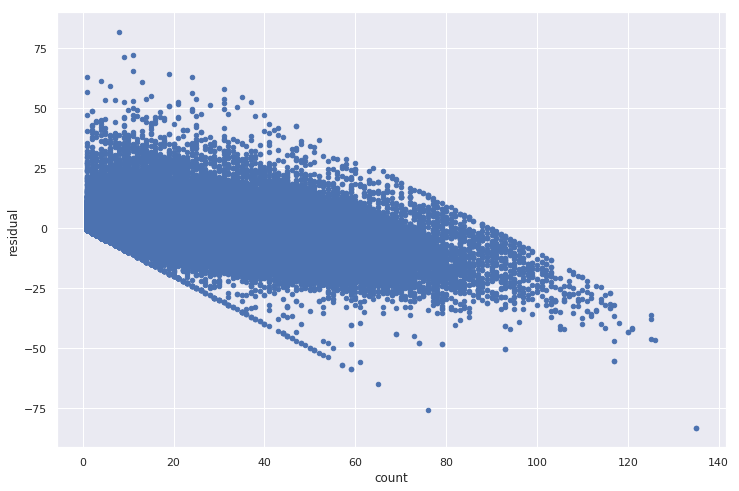

In [17]:
modelutils.show_prediction_stats(pred)